In [ ]:
import os
from dotenv import load_dotenv

load_dotenv()
os.chdir("../..")

DATA_DIR = os.getenv("DATA_DIR")
OUTPUT_DIR = os.getenv("OUTPUT_DIR")
MODEL_DIR = "/opt/gpudata/skin-cancer/models/few-shot/new/filtered"

In [3]:
import json
import pickle
from enum import IntEnum
from itertools import product
from pathlib import Path

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import torch
from matplotlib.colors import to_hex
from pyvis.network import Network
from seaborn import histplot

from models.nearest_centroid.nearest_centroid import NearestCentroid
from data_processing.label import NCLabel, Label
from data_processing.slide_utils import plot_image
from data_processing.data_utils import load_pickled_embeds

/home/sjne/miniconda3/envs/gigapath_clone/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sjne/miniconda3/envs/gigapath_clone/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/sjne/miniconda3/envs/gigapath_clone/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/sjne/miniconda3/envs/gigapath_clone/lib/python3.9/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprec

In [4]:
class TransLabel(IntEnum):
    benign = 0
    bowens = 1
    bcc_nodular = 2
    bcc_superficial = 3
    scc = 4
    artifact = 5

In [5]:
fm = "prism"
experiment = "sq_norm"
model = NearestCentroid(
    NCLabel, Path(MODEL_DIR, f"{fm}_param-{experiment}-agg.pkl")
)

In [6]:
def construct_transition_matrix(
    preds: torch.Tensor, coords: torch.Tensor, tile_size: int = 256
) -> tuple[nx.Graph, torch.Tensor]:
    """
    Constructs a transition matrix from the predictions and coordinates of
    tiles. Returns a graph and a transition matrix. Transitions are
    determined by the adjacency of tiles in a 3x3 grid around each tile.
    The transition matrix is normalized such that each row sums to 1.

    Parameters
    ----------
    preds : torch.Tensor
        The predicted labels for each tile

    coords : torch.Tensor
        The coordinates of each tile in the image

    tile_size : int
        The size of each tile in pixels. Default is 256

    Returns
    -------
    tuple[nx.Graph, torch.Tensor]
        A tuple containing the graph and the transition matrix. The
        transition matrix is a 2D tensor of shape (num_labels, num_labels)
    """
    G = nx.Graph()
    colors = [
        to_hex(plt.cm.inferno(i / (len(TransLabel) - 1)))
        for i in range(len(TransLabel))
    ]
    transitions = torch.zeros((len(TransLabel), len(TransLabel)))

    for idx, pred in enumerate(preds):
        # must convert to str for compat with pyvis
        node_str = str(coords[idx])
        pred_int = int(pred)
        G.add_node(node_str, label=pred_int, color=colors[pred_int])

        x, y = coords[idx]
        for dx, dy in product([-1, 0, 1], repeat=2):
            if dx == 0 and dy == 0:
                continue

            adj = str([x + dx * tile_size, y + dy * tile_size])
            if adj in G.nodes:
                G.add_edge(node_str, adj)

                # add the edge to the transitions matrix in both dirs
                i = pred_int
                j = G.nodes[adj]["label"]
                transitions[i][j] += 1
                transitions[j][i] += 1

    transitions = torch.div(transitions, transitions.sum(dim=-1, keepdim=True))
    return G, transitions

In [7]:
def bootstrap(
    iters: int, preds: torch.Tensor, coords: torch.Tensor, tile_size: int = 256
) -> torch.Tensor:
    """
    Returns a tensor of bootstrapped transition matrices. Each matrix is
    constructed by randomly permuting the predictions and then
    constructing the transition matrix. The transition matrices are
    stacked into a tensor.

    Parameters
    ----------
    iters : int
        The number of bootstrap iterations to perform

    preds : torch.Tensor
        The predicted labels for each tile

    coords : torch.Tensor
        The coordinates of each tile in the image

    tile_size : int
        The size of each tile in pixels. Default is 256

    Returns
    -------
    torch.Tensor
        A tensor of bootstrapped transition matrices; shape
        (iters, n_labels, n_labels)
    """
    bootstrapped = []
    coords_list = coords.tolist()
    for i in range(iters):
        # bootstrap the coordinates
        n = preds.shape[0]
        perm = torch.randperm(n)
        rand_preds = preds[perm]

        _, transitions = construct_transition_matrix(
            rand_preds.tolist(), coords_list, tile_size
        )
        bootstrapped.append(transitions)
        if i % 100 == 0 and i != 0:
            print(f"Bootstrap iteration {i} done")

    return torch.stack(bootstrapped, dim=0)

In [8]:
# get all slides that were annotated to use for analysis and bootstrapping

with open(
    "/opt/gpudata/skin-cancer/models/few-shot/new/intersects/config.json",
    "rb",
) as f:
    config = json.load(f)

slides = {lbl.name: [] for lbl in NCLabel}
for root, dirs, fs in os.walk(config["annotation_directory"]):
    for f in fs:
        if f.endswith(".geojson"):
            lbl = Path(root).stem
            slides[lbl].append(f[: -len(".geojson")])

slides["benign"] = slides["dermis_subcutis"]
del slides["dermis_subcutis"]
del slides["epidermis_corneum"]

In [ ]:
# save the slide list to a json file

with open(
    Path(OUTPUT_DIR, "few-shot", "transitions", "slide_lists.json"),
    "w",
) as f:
    json.dump(slides, f)

### Calc transition matrices and bootstrapped matrices

In [ ]:
# calculate the transition matrices for each slide and save to disk

# label_map = {lbl.value: lbl.name for lbl in TransLabel}
# transition_dfs = {lbl.name: [] for lbl in TransLabel}
# transition_tensors = {lbl.name: [] for lbl in TransLabel}

# for label, slide_ids in slides.items():
#     for slide in slide_ids:
#         path = Path(OUTPUT_DIR, fm, "tile_embeddings_sorted", f"{slide}.pkl")
#         embeds = load_pickled_embeds(path)

#         preds = model.predict(embeds["tile_embeds"].float()).argmax(dim=-1)

#         # switch to TransLabel classes
#         preds = torch.maximum(preds - 1, torch.zeros(preds.shape))

#         G, transitions = construct_transition_matrix(
#             preds.tolist(), embeds["coords"].tolist()
#         )

#         transition_tensors[label].append(transitions)

#         # row = from, column = to
#         df = pd.DataFrame(transitions)
#         df = df.rename(index=label_map, columns=label_map)
#         df.fillna(0, inplace=True)
#         transition_dfs[label].append(df)

#     transition_tensors[label] = torch.stack(
#         transition_tensors[label]
#     ).nan_to_num(nan=0)

#     with open(
#         Path(OUTPUT_DIR, "few-shot", "transitions", f"transitions-{label}.pt"),
#         "wb",
#     ) as f:
#         torch.save(transition_tensors[label], f)

In [ ]:
# bootstrap the transition matrices for each slide and save to disk

# import time

# bootstrapped = {lbl.name: [] for lbl in TransLabel}
# iters = 1000

# start = time.time()
# # for label, slide_ids in slides.items():
# for label in ["scc", "benign"]:
#     slide_ids = slides[label]
#     print(f"Bootstrapping {label} slides")
#     for slide in slide_ids:
#         path = Path(OUTPUT_DIR, fm, "tile_embeddings_sorted", f"{slide}.pkl")
#         embeds = load_pickled_embeds(path)

#         # reset preds to the new labels where 0 and 1 == benign
#         preds = model.predict(embeds["tile_embeds"].float()).argmax(dim=-1)
#         preds = preds - 1
#         preds[torch.where((preds == -1) | (preds == 0))] = 0

#         bootstrapped[label].append(bootstrap(iters, preds, embeds["coords"]))

#     bootstrapped[label] = torch.stack(bootstrapped[label]).nan_to_num(nan=0)
#     with open(
#         f"/opt/gpudata/skin-cancer/outputs/few-shot/transitions/bootstrapped-{label}-{iters}_iters.pt",
#         "wb",
#     ) as f:
#         torch.save(bootstrapped[label], f)

# print(time.time() - start)

Bootstrapping scc slides
Bootstrap iteration 100 done
Bootstrap iteration 200 done
Bootstrap iteration 300 done
Bootstrap iteration 400 done
Bootstrap iteration 500 done
Bootstrap iteration 600 done
Bootstrap iteration 700 done
Bootstrap iteration 800 done
Bootstrap iteration 900 done
Bootstrap iteration 100 done
Bootstrap iteration 200 done
Bootstrap iteration 300 done
Bootstrap iteration 400 done
Bootstrap iteration 500 done
Bootstrap iteration 600 done
Bootstrap iteration 700 done
Bootstrap iteration 800 done
Bootstrap iteration 900 done
Bootstrap iteration 100 done
Bootstrap iteration 200 done
Bootstrap iteration 300 done
Bootstrap iteration 400 done
Bootstrap iteration 500 done
Bootstrap iteration 600 done
Bootstrap iteration 700 done
Bootstrap iteration 800 done
Bootstrap iteration 900 done
Bootstrap iteration 100 done
Bootstrap iteration 200 done
Bootstrap iteration 300 done
Bootstrap iteration 400 done
Bootstrap iteration 500 done
Bootstrap iteration 600 done
Bootstrap iteratio

### Load saved transition matrices

In [9]:
transition_tensors = {lbl.name: [] for lbl in TransLabel}

for lbl in TransLabel:
    with open(
        Path(
            OUTPUT_DIR,
            "few-shot",
            "transitions",
            f"transitions-{lbl.name}.pt",
        ),
        "rb",
    ) as f:
        transition_tensors[lbl.name] = torch.load(f)

In [10]:
bootstrapped = {lbl.name: [] for lbl in TransLabel}

for lbl in TransLabel:
    try:
        with open(
            Path(
                OUTPUT_DIR,
                "few-shot",
                "transitions",
                f"bootstrapped-{lbl.name}-1000_iters.pt",
            ),
            "rb",
        ) as f:
            bootstrapped[lbl.name] = torch.load(f)
    except FileNotFoundError:
        print(f"Bootstrapped file not found for {lbl.name}. Skipping.")
        continue

Bootstrapped file not found for artifact. Skipping.


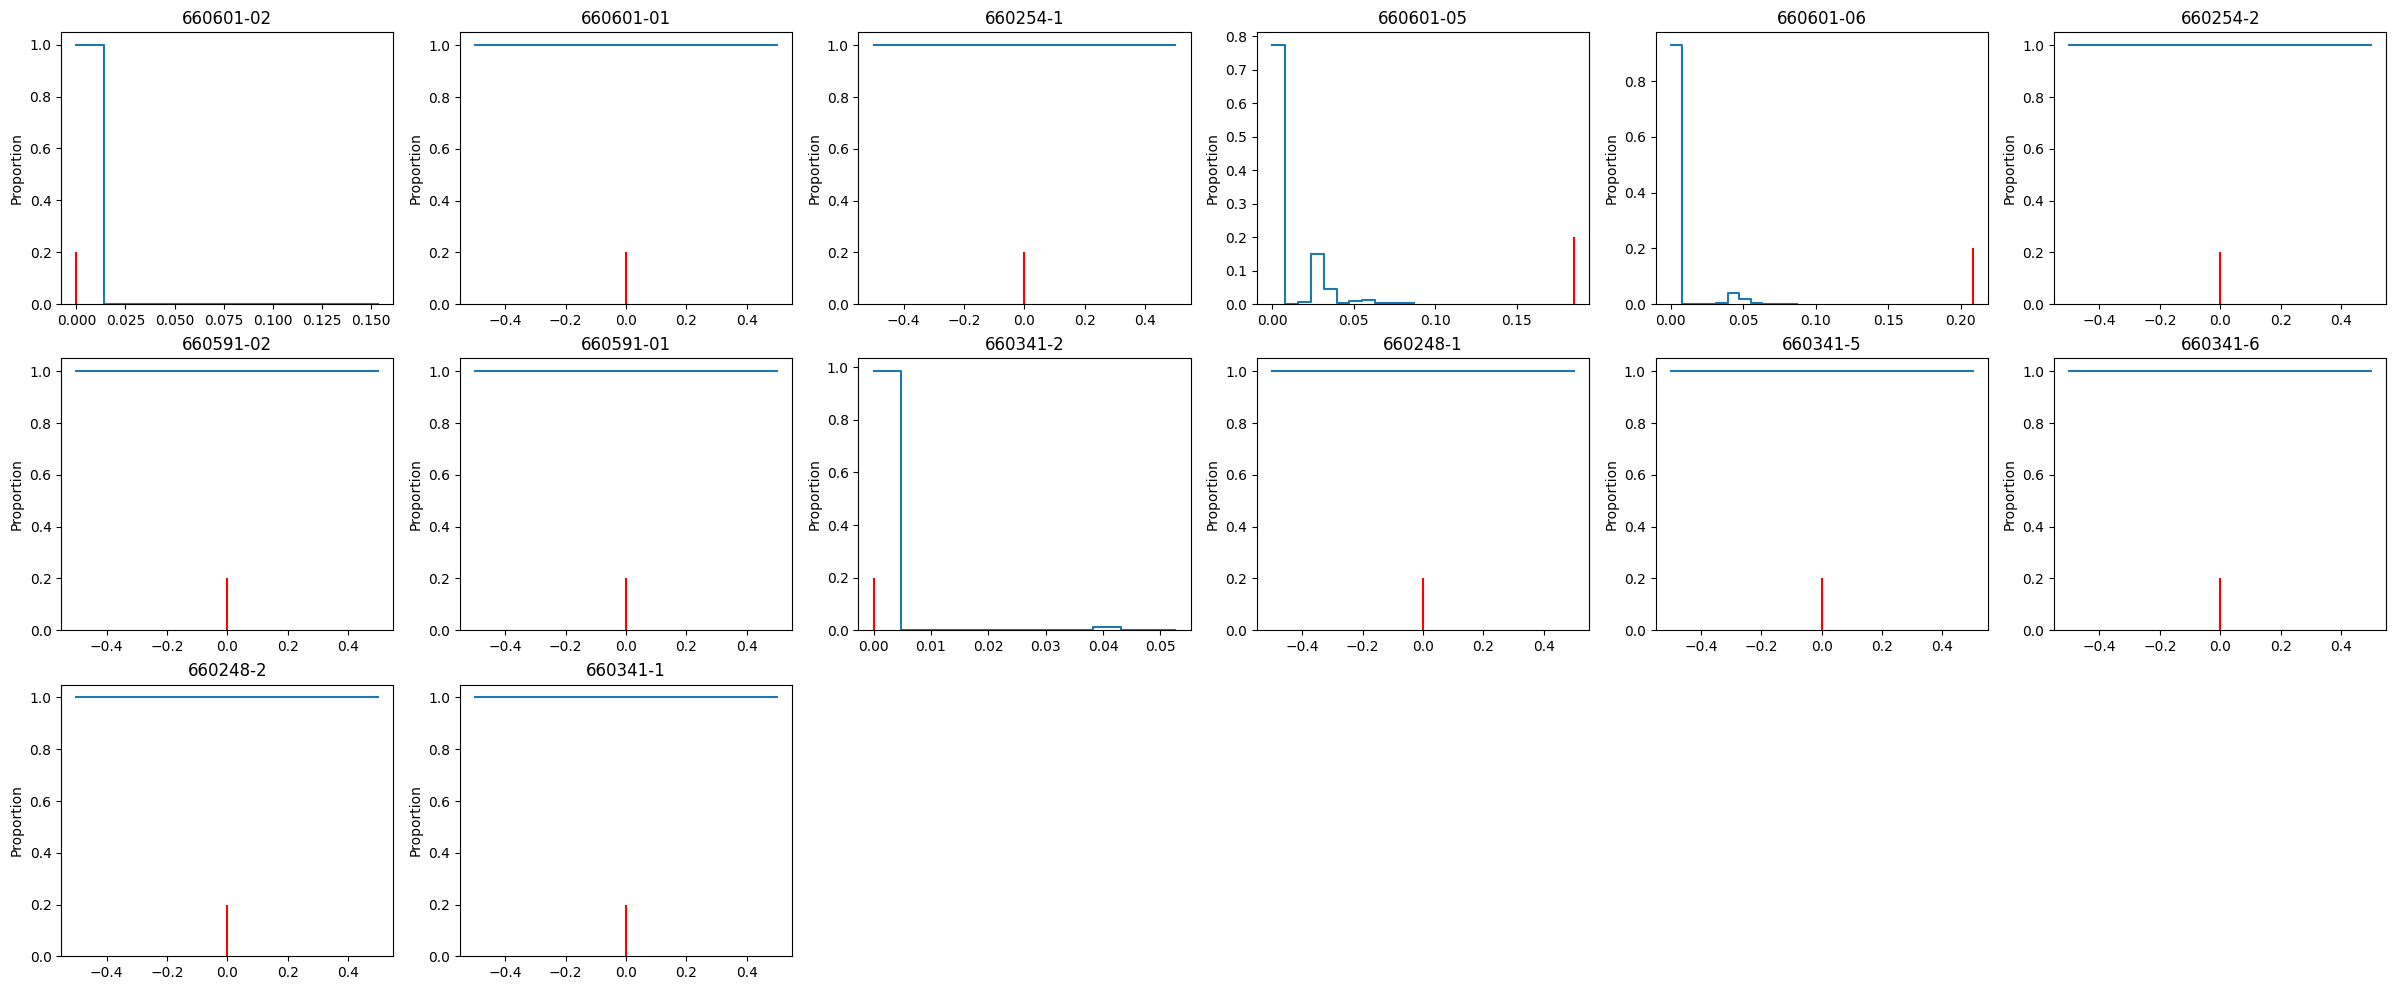

In [13]:
from seaborn import histplot
import matplotlib.pyplot as plt
from math import ceil

coi = "bowens"
n_slides = len(slides[coi])
_, axs = plt.subplots(
    ceil(n_slides / 6), 6, figsize=(30, 4 * ceil(n_slides / 6))
)
fr = 2
to = 2

for i in range(axs.shape[0] * axs.shape[1]):
    if i > n_slides - 1:
        axs[i // 6, i % 6].remove()
        continue

    ax = axs[i // 6, i % 6]
    colors = [to_hex(plt.cm.tab20(i / (14 - 1))) for i in range(14)]
    histplot(
        bootstrapped[coi][i, :, fr, to],
        element="step",
        stat="proportion",
        ax=ax,
        fill=False,
        # color=colors[i],
    )
    ax.vlines(
        [transition_tensors[coi][i, fr, to]],
        ymin=0,
        ymax=0.2,
        color="red",
    )
    ax.set_title(slides[coi][i])

In [7]:
# could use log-odds with frequencies of each based on the ROI filtering results
# p(bowens) is the # of tiles designated as bowens after filtering / total tiles in the slide

In [8]:
# average the transition matrices for each label to get a "reference" matrix
ref = {k: v.mean(dim=0) for k, v in transition_tensors.items()}
del ref["artifact"]

In [ ]:
# for each transition matrix of a particular label, multiply element-wise by the reference
# transition matrix for each label
class_of_interest = TransLabel(5)
lst = []
for label in TransLabel._member_names_[:-1]:
    lst.append(
        (transition_tensors[class_of_interest.name] * ref[label]).sum(
            dim=(1, 2)
        )
    )

In [34]:
# prediction is the argmax product for each slide
preds = torch.stack(lst).argmax(dim=0)
(preds == class_of_interest.value).sum() / preds.shape[0]

tensor(0.9565)

In [44]:
transition_dfs["bowens"][0]

,benign,bowens,bcc_nodular,bcc_superficial,scc,artifact
benign,0.963292,0.011709,0.000494,0.0,0.0,0.024505
bowens,0.620419,0.267016,0.000000,0.0,0.0,0.112565
bcc_nodular,1.000000,0.000000,0.000000,0.0,0.0,0.000000
bcc_superficial,0.000000,0.000000,0.000000,0.0,0.0,0.000000
scc,0.000000,0.000000,0.000000,0.0,0.0,0.000000
artifact,0.605617,0.052503,0.000000,0.0,0.0,0.341880


In [ ]:
coi = [0, 1]  # benign -> bowens

hist_data = {lbl.name: [] for lbl in TransLabel}
for label in transition_dfs:
    for matrix in transition_dfs[label]:
        fr = TransLabel(coi[0]).name
        to = TransLabel(coi[1]).name
        hist_data[label].append(matrix.loc[fr, to])

del hist_data["artifact"]

<Axes: ylabel='Proportion'>

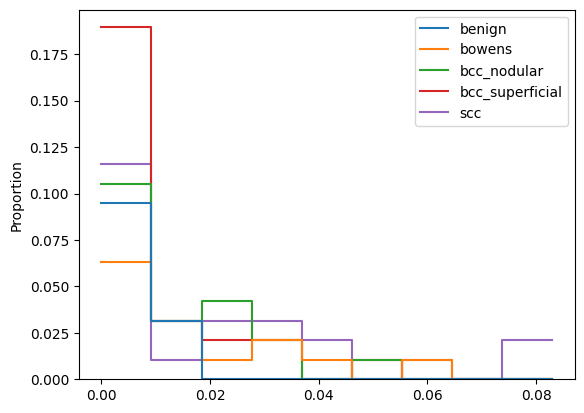

In [ ]:
# histogram shows the transition rates between COIs across annotated slides of each label
# e.g., yellow shows frequency of transitions from COI[0] to COI[1] on SCC ground truth slides
# colors = [plt.cm.inferno(i / (6 - 1)) for i in range(6)][:-1]
histplot(
    hist_data,
    element="step",
    fill=False,
    stat="proportion",
)